# Copernicus Atmosphere using ECMWFSearch plugin

In this tutorial we will show you how to use eodag to download data from providers using [ECMWFSearch](https://eodag.readthedocs.io/en/latest/plugins_reference/generated/eodag.plugins.search.build_search_result.ECMWFSearch.html) `eodag` plugin. You can currently find three providers that uses it, `cop_ads`, `cop_cds` and `cop_ewds`. For this tutorial we will use `cop_ads`, but `cop_cds` and `cop_ewds` are used the same way.

In [1]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()
dag.set_preferred_provider("cop_ads")

## Search (build download request)

There are two use cases, a search for a product already configured in EODAG, or a search for a dataset not already configured, where you will have a little more to do.

We can add a `variable` (Temperature, `temperature`) and one `model_level` to the request because `CAMS_EAC4` is configured to request for some pre-configured values. Check the dataset available values to make your selection.

> Note: specifying your own variables will completely overwrite default values configured for `CAMS_EAC4` product type.

### Check available queryables and default values:

Available queryables parameters and associated values can be checked using [list_queryables()](https://eodag.readthedocs.io/en/latest/notebooks/api_user_guide/4_search.html#Queryables) method, or through [cop_ads](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-global-reanalysis-eac4?tab=download) or [cop_cds](https://cds-beta.climate.copernicus.eu/datasets) websites:

In [2]:
queryables = dag.list_queryables(provider="cop_ads", productType="CAMS_EAC4")
queryables['ecmwf:variable']

typing.Annotated[typing.List[typing.Literal['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'black_carbon_aerosol_optical_depth_550nm', 'dust_aerosol_optical_depth_550nm', 'high_cloud_cover', 'high_vegetation_cover', 'lake_cover', 'land_sea_mask', 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation', 'lifting_threshold_speed', 'low_cloud_cover', 'low_vegetation_cover', 'mean_altitude_of_maximum_injection', 'mean_sea_level_pressure', 'medium_cloud_cover', 'near_ir_albedo_for_diffuse_radiation', 'near_ir_albedo_for_direct_radiation', 'organic_matter_aerosol_optical_depth_550nm', 'particulate_matter_10um', 'particulate_matter_1um', 'particulate_matter_2.5um', 'sea_ice_cover', 'sea_salt_aerosol_optical_depth_550nm', 'sea_surface_temperature', 'skin_reservoir_content', 'skin_temperature', 'snow_albedo', 'snow_depth', 'soil_clay_content', 'soil_type', 'sulphate_aerosol_optical_depth_550nm', 'surface_geopotential', 'surface_pre

Here we can see the list of available values for `variable`, and that the default value configured for `CAMS_EAC4` is `2m_dewpoint_temperature`

### Search from an existing product type:

In [3]:
# Request for all parameters
products_from_product_type = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    productType="CAMS_EAC4",
    count=True
)
print(
    "%s product built %s,\n having variable = %s\n"
    % (
        products_from_product_type.number_matched,
        products_from_product_type[0],
        products_from_product_type[0].properties.get("ecmwf:variable"),
    )
)
# Request for temperature on one model level
products_from_product_type = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    productType="CAMS_EAC4",
    count=True,
    **{"ecmwf:variable": "temperature",
       "ecmwf:model_level": "1"},

)
print(
    "%s product built %s,\n having variable = %s\n"
    % (
        products_from_product_type.number_matched,
        products_from_product_type[0],
        products_from_product_type[0].properties.get("ecmwf:variable"),
    )
)

1 product built EOProduct(id=CAMS_EAC4_20210101_20210102_6b7cb619839dcb7699d24d04cef67121d47f8348, provider=cop_ads),
 having variable = 2m_dewpoint_temperature

1 product built EOProduct(id=CAMS_EAC4_20210101_20210102_4a4a8a1a556e215789bbedbe797bed4292fece99, provider=cop_ads),
 having variable = temperature



### Search using a custom request:

Here we will use a set of custom parameters corresponding to `CAMS_EAC4`, which should result to the same request sent to ads.

In [4]:
ads_req_params = {
    "ecmwf:dataset": "cams-global-reanalysis-eac4",
    "ecmwf:variable": "temperature",
    "ecmwf:model_level": "1",
    "ecmwf:time": "00:00",
    "ecmwf:data_format": "grib",
}

products_from_ads_req = dag.search(
    provider="cop_ads",
    start="2021-01-01",
    end="2021-01-02",
    **ads_req_params,
)

# orderLink property must be the same with the two request methods,
# as they are built from the same ADS request arguments
if (
    products_from_ads_req[0].properties["orderLink"]
    == products_from_product_type[0].properties["orderLink"]
):
    print(
        "Request using productType or directly ADS parameters result to the\n",
        "same orderLink %s"
        % (
            products_from_ads_req[0].properties["orderLink"],
        )
    )

Request using productType or directly ADS parameters result to the
 same orderLink https://ads.atmosphere.copernicus.eu/api/retrieve/v1/processes/cams-global-reanalysis-eac4/execution?{"inputs": {"data_format": "grib", "date": ["2021-01-01/2021-01-02"], "model_level": "1", "time": "00:00", "variable": "temperature"}}


### Send product retrieval request, download when available and return an `xarray.DataArray`

- download performed using ADS credentials set in `~/.config/eodag/eodag.yml` as for other EO providers:
```yaml
    cop_ads:
        priority:
        download:
            output_dir: /my/path/to/data/eodag_data
        auth:
            credentials:
                apikey: myapikey
```
- you can check your request status from https://ads-beta.atmosphere.copernicus.eu/requests?tab=all
- See [support](https://ads-beta.atmosphere.copernicus.eu/help) for any problem related to the provider

In [5]:
product = products_from_ads_req[0]
da = product.get_data(r"\.grib$", extent={'lonmin': -12, 'latmin': 32, 'lonmax': 48, 'latmax': 72})

/tmp/ipykernel_77561/2673004571.py:2: DeprecationWarning: Call to deprecated function/method get_data (Use to_xarray instead)
  da = product.get_data(r"\.grib$", extent={'lonmin': -12, 'latmin': 32, 'lonmax': 48, 'latmax': 72})


0.00B [00:00, ?B/s]

## Plot using cartopy

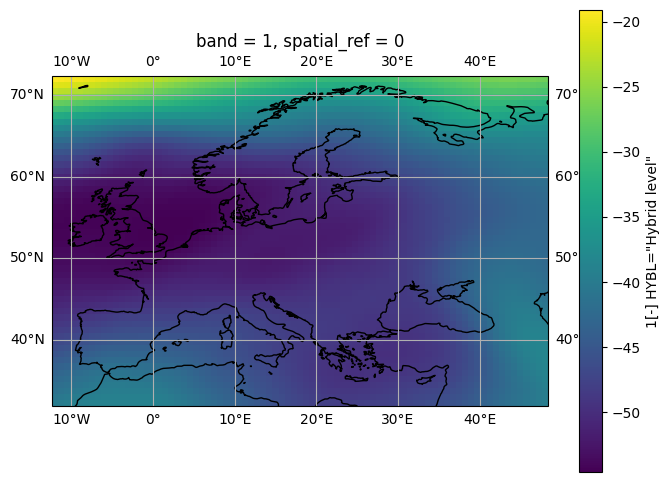

In [6]:
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

band1 = da[0]
band1.plot(ax=ax, transform=crs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True);